# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо решить, где бурить новую скважину. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import os
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy import stats as st

Объявим необходимые для дальнейших шагов переменные. 

Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [2]:
STATE = RandomState(12345) 
BOOTSRAP_SAMPLE = 1000

In [3]:
REVENUE_PRODUCT = 450_000 # доход с одной единицы продукта
COUNT_TOTAL_WELL = 500 # количество скважин для разработки в регионе
COUNT_WELL = 200 # количество самых прибыльных из выбранных скважин для разработки

BUDGET = 10_000_000_000
BUDGET_WELL = BUDGET / COUNT_WELL
BREAK_EVEN = BUDGET / REVENUE_PRODUCT
BREAK_EVEN_WELL = BREAK_EVEN / COUNT_WELL

In [4]:
if os.path.exists('/datasets/geo_data_0.csv'):
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
else:
    geo_0 = pd.read_csv('geo_data_0.csv')
geo_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [5]:
def info_dataframe(df):
    print('Общая информация по dataframe:')
    print('')
    df.info()
    print('')
    print('Найдено полных дублей:', df.duplicated().sum())
    print('')
    print('Найдено дублей по столбцу id:', df['id'].duplicated().sum())
    print('')
    print('Статистика по пропускам:')
    print(df.isna().sum())
    print('')
    print('Статистика по признакам:')
    display(df.describe().T)
    print('')
    print('Коэффициенты корреляции:')
    print(df.corr()) 
    pd.plotting.scatter_matrix(df, figsize=(9, 9));

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Найдено полных дублей: 0

Найдено дублей по столбцу id: 10

Статистика по пропускам:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Статистика по признакам:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


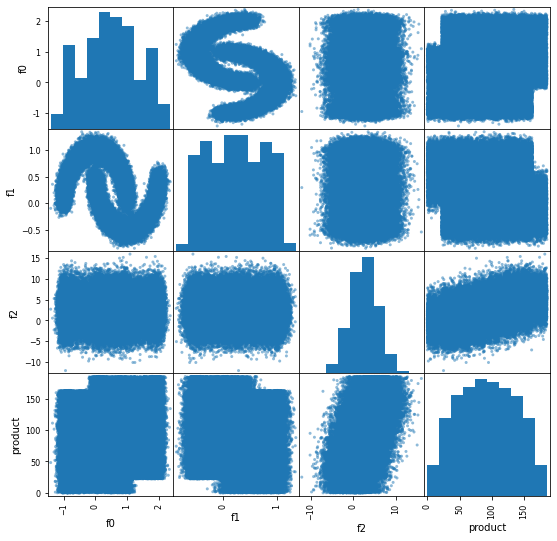

In [6]:
info_dataframe(geo_0)


Полных дублей нет, пропусков данных нет, судя по коэффициенту корреляции данные либо не связаны, либо слабо связаны между собой. Есть 10 строк с дублями по столбцу id.


In [7]:
if os.path.exists('/datasets/geo_data_1.csv'):
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
else:
    geo_1 = pd.read_csv('geo_data_1.csv')
geo_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Найдено полных дублей: 0

Найдено дублей по столбцу id: 4

Статистика по пропускам:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Статистика по признакам:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


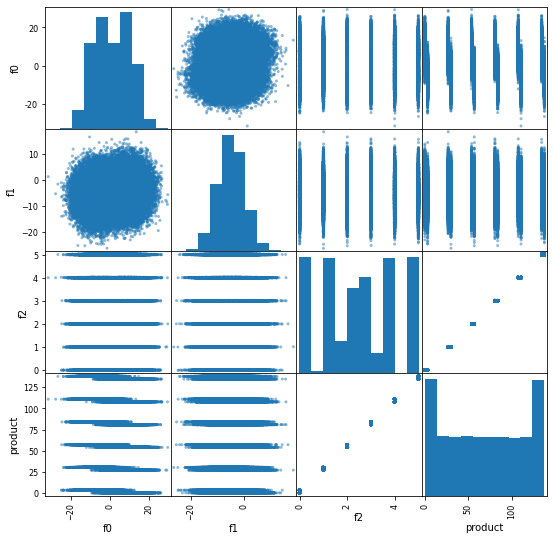

In [8]:
info_dataframe(geo_1)

Полных дублей нет, есть немного дублирующих значений по столбу id. Пропусков данных нет, судя по коэффициенту корреляции есть сильная связь между признаками f2 и product.

In [9]:
if os.path.exists('/datasets/geo_data_2.csv'):
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
else:
    geo_2 = pd.read_csv('geo_data_2.csv')
geo_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Найдено полных дублей: 0

Найдено дублей по столбцу id: 4

Статистика по пропускам:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Статистика по признакам:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


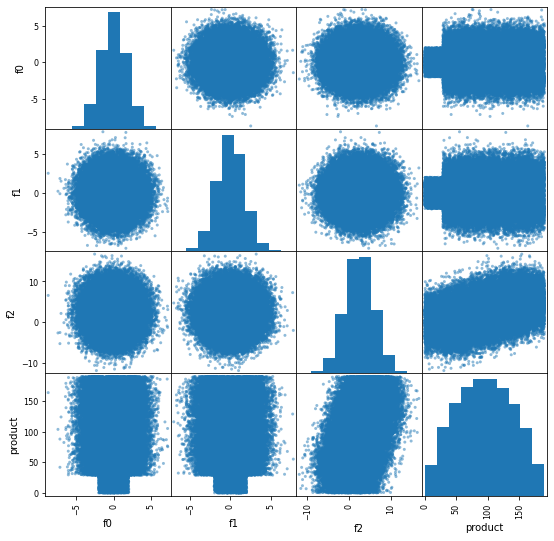

In [10]:
info_dataframe(geo_2)

Пропусков в данных нет. Явных дублей тоже. Есть небольшое количество дублей по столбцу id.

Удалим дубли по столбцу id.

In [11]:
def drop_duplicates_id(df):
    df['id'] = df['id'].drop_duplicates()

In [12]:
drop_duplicates_id(geo_0)
drop_duplicates_id(geo_1)
drop_duplicates_id(geo_2)

Удалим поле id, т.к. оно не значимо для обучения модели.

In [23]:
def drop_column_id(df):
    return df.drop(['id'], axis=1)

In [24]:
geo_0 = drop_column_id(geo_0)
geo_1 = drop_column_id(geo_1)
geo_2 = drop_column_id(geo_2)

**Вывод** 

Пропусков в данных нет. Удалено небольшое количество дублей по столбцу id. В каждом наборе по 100 тыс строк. Данные уже предобработаны.

Медианные значения объемов запасов:
* для набора 0 - 91.849972	
* для набора 1 - 57.085625
* для набора 2 - 94.925613.

Для набора данных 1 наблюдаются выбросы по нижней и верхней границам, при том, что у большей части скважин объем запасов на уровне 60 тыс. баррелей, таким образом, много скважин с очень низким и очень высоким объемом запасов. Распределение объема запасов для набора данных 0 и 2 близко к нормальному.

Во втором наборе данных наблюдается сильная взаимосвязь между признаками f2 и product. Это может повлиять на качество модели линейной регрессии (эффект мультиколлинеарности).

## Обучение и проверка модели

Построим модель для каждого набора данных. посчитаем средний запас предсказанного сырья и метрику RMSE.

In [35]:
def train_model(df):
    
    
    features = df.drop(['product'], axis=1)
    target = df['product'] 
    
    features_train, features_valid, target_train, target_valid = train_test_split(
                               features, target, test_size=0.25, random_state=STATE)
    
    model = LinearRegression()# инициализируйте модель LinearRegression
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке

    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    
    product_mean = round(predictions_valid.mean(), 2)
    
    return rmse, product_mean, predictions_valid, target_valid

In [36]:
rmse_0, product_mean_0, predictions_valid_0, target_valid_0 = train_model(geo_0)
print('Средний запас предсказанного сырья для региона 0:', product_mean_0)
print('RMSE модели первого региона:', rmse_0)

Средний запас предсказанного сырья для региона 0: 92.48
RMSE модели первого региона: 37.71966448767512


In [37]:
rmse_1, product_mean_1, predictions_valid_1, target_valid_1 = train_model(geo_1)
print('Средний запас предсказанного сырья для региона 1:', product_mean_1)
print('RMSE модели первого региона:', rmse_1)

Средний запас предсказанного сырья для региона 1: 69.01
RMSE модели первого региона: 0.8924017382973587


In [38]:
rmse_2, product_mean_2, predictions_valid_2, target_valid_2 = train_model(geo_2)
print('Средний запас предсказанного сырья для региона 2:', product_mean_2)
print('RMSE модели первого региона:', rmse_2)

Средний запас предсказанного сырья для региона 2: 94.97
RMSE модели первого региона: 40.20637032410798


Проверим, что без признака f2 результат модели не поменяется.

In [39]:
rmse_1_tmp, product_mean_1_tmp, predictions_valid_1_tmp, target_valid_1_tmp = train_model(geo_1.drop(['f2'], axis=1))
print('Средний запас предсказанного сырья для региона 1 без признака f2:', product_mean_1_tmp)
print('RMSE модели первого региона:', rmse_1_tmp)

Средний запас предсказанного сырья для региона 1 без признака f2: 68.92
RMSE модели первого региона: 45.989341690696136


Удаление признака не повлияло на средний запас, но значительно повлияло на значение RMSE. Эта модель значительно менее эффективна, чем первая с признаком f2.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. 

Выведем объем сырья для безубыточной разработки скважины.

In [30]:
print('Бюджет на разработку скважины:', round(BUDGET_WELL, 2))
print('Объем сырья со всех скважин для безубыточной разработки региона:', round(BREAK_EVEN, 2))
print('Объем сырья для безубыточной разработки одной скважины:', round(BREAK_EVEN_WELL, 2))

Бюджет на разработку скважины: 50000000.0
Объем сырья со всех скважин для безубыточной разработки региона: 22222.22
Объем сырья для безубыточной разработки одной скважины: 111.11


Сравним показатель объема со средними предсказанными значениями по регионам.

In [48]:
def break_even(product_mean):
    if product_mean > BREAK_EVEN_WELL:
        print(f'Предсказанное среднее значение в регионе {product_mean} больше объема в точке безубыточности {round(BREAK_EVEN_WELL, 2)}')
    else:
        print(f'Предсказанное среднее значение в регионе {product_mean} меньше объема в точке безубыточности {round(BREAK_EVEN_WELL, 2)}')

In [49]:
break_even(product_mean_0)

Предсказанное среднее значение в регионе 92.48 меньше объема в точке безубыточности 111.11


In [50]:
break_even(product_mean_1)

Предсказанное среднее значение в регионе 69.01 меньше объема в точке безубыточности 111.11


In [51]:
break_even(product_mean_2)

Предсказанное среднее значение в регионе 94.97 меньше объема в точке безубыточности 111.11


**Вывод**

Объем сырья для безубыточной разработки скважины выше средних значений по всем регионам. Ближе всего показатели средних значений из региона 0 (92.48) и региона 2 (94,97). 

Учитывая, что будет разработано только 200 точек, по которым предполагается, что они будут самыми прибыльными, а в предсказании используются данные 25 тыс точек, необходимо выбрать случайным образом по 500 точек для разработки, из них 200 самых прибыльных и оценить прибыль, которую возможно получить с каждого региона, оценив и риски убытков. Процедуру случайного выбора повторить 1000 раз.

## Расчёт прибыли и рисков 

Создадим функцию для расчета реальной прибыльности региона с выбором по прогнозным объемам добычи.

In [63]:
def revenue(target, predictions):
    
    predictions = pd.Series(predictions)
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:COUNT_WELL]

    # вычтем из дохода, полученного от добычи на выбранных скважинах, бюджет на разработку 
    return round((REVENUE_PRODUCT * selected.sum() - BUDGET) / 1_000_000, 2)  # в миллионах

Техникой bootsrap с 1000 выборок найдем распределение прибыли. Оценим 95%-й доверительный интервал и риск убытков для региона. 

In [64]:
def get_distibution_revenue(target, predictions):
    
    predictions = pd.Series(predictions, index = target.index)

    values = [] # реальная выручка по самым прибыльным из предсказанных скважин
    for i in range(BOOTSRAP_SAMPLE):
        subsample_t = target.sample(n=COUNT_TOTAL_WELL, replace=True, random_state=STATE)
        subsample_p = predictions[subsample_t.index]
        rev = revenue(subsample_t ,subsample_p)
        values.append(rev)

    values = pd.Series(values)
    revenue_mean = round(values.mean(), 2)
    quantile_lower = round(values.quantile(0.025), 2)
    quantile_upper = round(values.quantile(0.975), 2)
    
    unprofitable = [elem for elem in values if elem < 0]
    risk = round(len(unprofitable)/ BOOTSRAP_SAMPLE * 100, 2) # процент убыточных скважин
    
    #confidence_interval = st.t.interval(0.95, len(values), loc=revenue_mean, scale=values.sem())
    
    return revenue_mean, quantile_lower, quantile_upper, risk

In [66]:
revenue_mean_0, quantile_lower_0, quantile_upper_0, risks_mean_0 = get_distibution_revenue(target_valid_0, predictions_valid_0)

print(f'Средняя прибыль по региону 0: {revenue_mean_0} млн. руб.')
print('С 95% вероятностью прибыль попадет в интервал:', quantile_lower_0, quantile_upper_0)
print('Риск убыточных скважин:', risks_mean_0)

Средняя прибыль по региону 0: 476.97 млн. руб.
С 95% вероятностью прибыль попадет в интервал: -45.11 996.59
Риск убыточных скважин: 3.7


In [67]:
revenue_mean_1, quantile_lower_1, quantile_upper_1, risks_mean_1 = get_distibution_revenue(target_valid_1, predictions_valid_1)

print(f'Средняя прибыль по региону 1: {revenue_mean_1} млн. руб.')
print('С 95% вероятностью прибыль попадет в интервал:', quantile_lower_1, quantile_upper_1)
print('Риск убыточных скважин:', risks_mean_1)

Средняя прибыль по региону 1: 512.69 млн. руб.
С 95% вероятностью прибыль попадет в интервал: 72.21 981.42
Риск убыточных скважин: 1.4


In [68]:
revenue_mean_2, quantile_lower_2, quantile_upper_2, risks_mean_2 = get_distibution_revenue(target_valid_2, predictions_valid_2)

print(f'Средняя прибыль по региону 2: {revenue_mean_2} млн. руб.')
print('С 95% вероятностью прибыль попадет в интервал:', quantile_lower_2, quantile_upper_2)
print('Риск убыточных скважин:', risks_mean_2)

Средняя прибыль по региону 2: 432.32 млн. руб.
С 95% вероятностью прибыль попадет в интервал: -110.52 985.5
Риск убыточных скважин: 5.9


По условию нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Под данное условие подходит только второй регион. Среднее значения прибыли также выше по второму региону, несмотря на то, что средние значения добычи были меньше чем в регионах 0 и 2.

# Выводы

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо решить, где бурить новую скважину.

В данных нет пропусков, дублей. 

Средние значения объемов запасов:

для набора 0 - 92.4
для набора 1 - 68.8
для набора 2 - 95.0

Для набора данных 1 наблюдаются выбросы по нижней и верхней границам, при том, что у большей части скважин объем запасов на уровне 60 тыс. баррелей.

Во втором наборе данных наблюдается сильная взаимосвязь между признаками f2 и product. Но это не повлияло на качество модели линейной регрессии (эффект мультиколлинеарности).

Была построена модель машинного обучения и рассчитана прибыльность от разработки скважин.
Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбираются 200 лучших для разработки.
У региона 1 самый низкий риск получить убытки (меньше 1%), а средняя прибыльно
